# Code

First open the log file

In [1]:
import requests

urlOfLog = "https://raw.githubusercontent.com/brightnetwork/ieuk-task-2025/refs/heads/main/sample-log.log"
response = requests.get(urlOfLog)

# Check if the request was successful
if response.status_code == 200:
    logContent = response.text.strip().splitlines()
    print("Successfully opened log file")
    print(logContent[:5])
else:
    print("Failed to fetch the file. Status code: %s" % (response.status_code))

Successfully opened log file
['100.34.17.233 - NO - [01/07/2025:06:00:02] "GET /news/grammy-nominations-2024 HTTP/1.1" 302 1234 "-" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36" 269', '173.80.18.254 - NO - [01/07/2025:06:00:04] "POST / HTTP/1.1" 200 1234 "-" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36" 124', '10.3.0.48 - SE - [01/07/2025:06:00:06] "GET /podcasts/behind-the-beat HTTP/1.1" 200 1234 "-" "Mozilla/5.0 (iPhone; CPU iPhone OS 17_2_1 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/17.2 Mobile/15E148 Safari/604.1" 284', '172.56.143.33 - US - [01/07/2025:06:00:08] "GET /terms-of-service HTTP/1.1" 200 1234 "-" "Mozilla/5.0 (iPhone; CPU iPhone OS 17_2_1 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/17.2 Mobile/15E148 Safari/604.1" 262', '208.54.157.184 - NO - [01/07/2025:06:00:09] "POST /privacy-polic

Now split each row of data into columns so its easy to read and access

In [2]:
import pandas as pd
import re

pattern = re.compile(
    r'(\S+)\s+-\s+(\S+)\s+-\s+\[(.*?)\]\s+"(\S+)\s+(.*?)\s+(HTTP/\d\.\d)"\s+(\d+)\s+(\d+)\s+"(.*?)"\s+"(.*?)"\s+(\d+)'
)

parsed_rows = []

for line in logContent:
    m = pattern.match(line)
    if m:
        parsed_rows.append(list(m.groups()))

# Define columns
columns = [
    'ip',
    'country',
    'datetime',
    'method',
    'path',
    'protocol',
    'status',
    'size',
    'referrer',
    'user_agent',
    'duration'
]

# Create DataFrame
df = pd.DataFrame(parsed_rows, columns=columns)

print(df)

                    ip country             datetime method  \
0        100.34.17.233      NO  01/07/2025:06:00:02    GET   
1        173.80.18.254      NO  01/07/2025:06:00:04   POST   
2            10.3.0.48      SE  01/07/2025:06:00:06    GET   
3        172.56.143.33      US  01/07/2025:06:00:08    GET   
4       208.54.157.184      NO  01/07/2025:06:00:09   POST   
...                ...     ...                  ...    ...   
432091     10.11.0.242      SE  04/07/2025:22:59:45    GET   
432092  173.161.113.97      DK  04/07/2025:22:59:46    GET   
432093     81.3.240.99      FR  04/07/2025:22:59:51    GET   
432094    174.53.3.214      DE  04/07/2025:22:59:54   POST   
432095  108.48.154.231      NL  04/07/2025:22:59:59    GET   

                                        path  protocol status  size referrer  \
0              /news/grammy-nominations-2024  HTTP/1.1    302  1234        -   
1                                          /  HTTP/1.1    200  1234        -   
2              

Now let's plot the duration of each request, see how much time connections to the server spend loading the Webpage

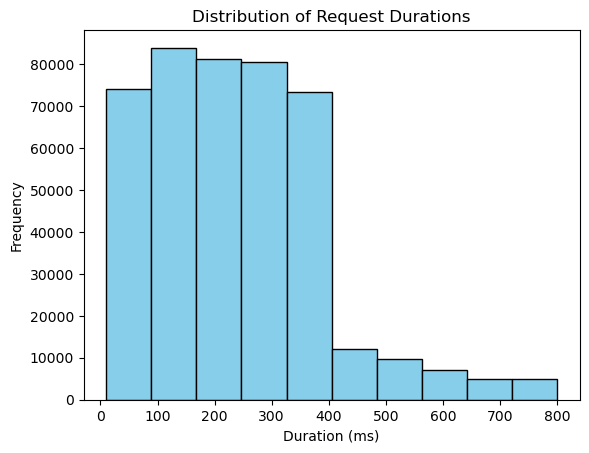

In [3]:
import matplotlib.pyplot as plt

df['duration'] = pd.to_numeric(df['duration'], errors='coerce')
plt.hist(df['duration'], bins=10, color='skyblue', edgecolor='black')
plt.title('Distribution of Request Durations')
plt.xlabel('Duration (ms)')
plt.ylabel('Frequency')
plt.show()

This graph suggest that request under 400ms could be a bot, but this is not definite.

Now let's find ip address which have a suspicious amount of request within one minute

In [4]:
df['datetime'] = pd.to_datetime(df['datetime'], format='%d/%m/%Y:%H:%M:%S')
df = df.set_index('datetime')

In [5]:
requests_per_minute = (
    df
    .groupby('ip')
    .resample('1min')
    .size()
    .reset_index(name='request_count')
)


In [6]:
suspicious = requests_per_minute[requests_per_minute['request_count'] > 40]
print(suspicious)
suspicious_ips = df['ip'].unique()
print(suspicious_ips)

                   ip            datetime  request_count
16689703  194.168.1.1 2025-07-03 12:45:00             41
16689711  194.168.1.1 2025-07-03 12:53:00             42
16689766  194.168.1.2 2025-07-03 12:48:00             42
16689769  194.168.1.2 2025-07-03 12:51:00             42
16689836  194.168.1.3 2025-07-03 12:58:00             41
...               ...                 ...            ...
19217780   45.133.1.2 2025-07-02 15:55:00             90
19217781   45.133.1.2 2025-07-02 15:56:00             90
19217782   45.133.1.2 2025-07-02 15:57:00             90
19217783   45.133.1.2 2025-07-02 15:58:00             90
19217784   45.133.1.2 2025-07-02 15:59:00             90

[163 rows x 3 columns]
['100.34.17.233' '173.80.18.254' '10.3.0.48' ... '185.220.101.19'
 '185.220.101.78' '185.220.100.77']


Here we have almost 200 suspicious ips for doing many request to the server under a minute

# Report

Here we have identified ip addresses that could be bots. This means when the server receives a request from one of these ip addresses, it should request a Captcha to verify if the connection is human or not. By using a Captcha it ensures that the company does not lose users, as blocking all of the ip addresses could risk losing real users. Also, ip addresses are not unique, meaning the ip address could be both a bot or sometimes a human. This solution is cheap and easy to impliment into a website.